In [1]:
%load_ext autoreload
%autoreload 2

In [222]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torch.autograd import grad

import matplotlib.pyplot as plt

import random
import numpy as np

In [267]:
def mlp(X, W):
    act = nn.LeakyReLU(0.1)
    W1, W2, W3 = W
    return W3 @ act(W2 @ act(W1 @ X))


def ce_loss(batch, W, acc=False):
    device = W[0].device
    ce = nn.CrossEntropyLoss()

    images, targets = batch[0].to(device), batch[1].to(device)
    logits = mlp(images.flatten(start_dim=1).T, W).T
    loss = ce(logits, targets)
    if not acc:
        return loss

    accuracy = (torch.argmax(logits, -1) == targets).detach().cpu().numpy()
    return loss, np.mean(accuracy)

In [390]:
act = nn.LeakyReLU(0.1)
act_inv = nn.LeakyReLU(10)


def linear(*shape):
    W = torch.empty(*shape)
    stdv = 1. / np.sqrt(W.shape[1])
    W.uniform_(-stdv, stdv).requires_grad_(True)
    return W


def init_W(dim=512, device='cpu'):
    W1 = linear(dim, 28 * 28)
    W2 = linear(dim, dim)
    W3 = linear(10, dim)
    return nn.ParameterList([W1, W2, W3]).to(device)


def transform12(X, W, T):
    W1, W2, W3 = W
    
    g = torch.eye(T.shape[0]) + T
    g_inv = torch.eye(T.shape[0]) - T
    
    h = X
    h_inv = torch.linalg.pinv(h)

    return [
        act_inv(g @ act(W1 @ h)) @ h_inv,
        W2 @ g_inv,
        W3
    ]


def transform23(X, W, T):
    W1, W2, W3 = W
    
    g = torch.eye(T.shape[0]) + T
    g_inv = torch.eye(T.shape[0]) - T
    
    h = act(W1 @ X)
    h_inv = torch.linalg.pinv(h)

    return [
        W1,
        act_inv(g @ act(W2 @ h)) @ h_inv,
        W3 @ g_inv
    ]


def symmetry_teleportation(W, batch, loss_f, teleport_lr, inner_iters):
    device = W[0].device
    images, targets = batch[0].to(device), batch[1].to(device)
    images = images.flatten(start_dim=1).T

    T = torch.zeros(2, 512, 512, requires_grad=True)

    opt = torch.optim.SGD([T], lr=teleport_lr, maximize=True)
    for i in range(inner_iters):
        W_ = transform12(images, W, T[0])
        W_ = transform23(images, W_, T[1])
        
        loss = loss_f(batch, W_)
        grads = grad(loss, W_, create_graph=True)

        opt.zero_grad()
        grads = torch.cat([g.view(-1) for g in grads])
        grad_norm_sq = grads.square().sum()
        T.grad = grad(grad_norm_sq, [T])[0]
        torch.nn.utils.clip_grad_norm_(T, 5)
        opt.step()

    
    print('norm', grad_norm_sq.item(), torch.norm(T).item())
    W = transform12(images, W, T[0])
    W = transform23(images, W, T[1])
    return W


def evaluate(W, val_dataloader, loss_f=ce_loss):
    losses, accs = [], []
    for batch in val_dataloader:
        loss, acc = loss_f(batch, W, acc=True)
        losses.append(loss.item())
        accs.append(acc)
    
    return np.mean(losses), np.mean(accs)
    

def mnist_grad_descent(train_dataloader, val_dataloader, teleport_epoches=[], loss_f=ce_loss,
                       lr=2e-3, epochs=80, teleport_lr=1e-3, inner_iters=10, teleport_steps=4):
    seed = 0
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    random.seed(seed)
    np.random.seed(seed)

    loss_history, val_loss_history, grad_norm_history = [], [], []
    acc_train_history, acc_val_history = [], []

    W = init_W(dim=512)
    opt = torch.optim.SGD(W, lr=lr)

    for epoch in tqdm(range(epochs)):
        # teleportation
        if epoch in teleport_epoches:
            for j, batch in enumerate(train_dataloader):
                if j == teleport_steps:
                    break

                W = symmetry_teleportation(W, batch, loss_f, teleport_lr, inner_iters)
                for k in range(len(W)):
                    W[k] = W[k].clone().detach().requires_grad_(True)

                opt = torch.optim.SGD(W, lr=lr)
                opt.zero_grad()

        epoch_losses, epoch_norms = [], []
        acc_train = []
        for batch in train_dataloader:
            opt.zero_grad()
            loss, acc = loss_f(batch, W, acc=True)
            loss.backward()

            acc_train.append(acc)
            epoch_losses.append(loss.item())
            grad = torch.cat([w.grad.view(-1) for w in W])
            epoch_norms.append(torch.norm(grad).item())
            torch.nn.utils.clip_grad_norm_(W, 5)
            opt.step()

        acc_train_history.append(np.mean(acc_train))

        loss_history.append(np.mean(epoch_losses))
        grad_norm_history.append(np.mean(epoch_norms))
        
        val_loss, acc = evaluate(W, val_dataloader, loss_f=loss_f)
        val_loss_history.append(val_loss)
        acc_val_history.append(acc)
        
        print(np.mean(epoch_losses))

    return loss_history, val_loss_history, grad_norm_history, acc_train_history, acc_val_history

In [449]:
import torchvision

train_data = torchvision.datasets.MNIST(root='./data', train=True, 
    transform=torchvision.transforms.ToTensor(), download=True)

val_data = torch.utils.data.Subset(train_data, range(48000, 60000))
train_data = torch.utils.data.Subset(train_data, range(48000))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=20, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=20, shuffle=False)

In [454]:
results = {}

teleport_epoches_sets = [[], [1], [2], [1, 7, 13, 19]]
for teleport_epoches in teleport_epoches_sets:
    train_loss_history, val_loss_history, norm_hist, acc_train_history, acc_val_history = mnist_grad_descent(
        train_loader, val_loader, teleport_epoches=teleport_epoches,
        epochs=80, lr=2e-3, teleport_lr=1e-3, inner_iters=10
    )
    results[f'{teleport_epoches}'] = (train_loss_history, val_loss_history,
                                      norm_hist, acc_train_history, acc_val_history)

  0%|          | 0/80 [00:00<?, ?it/s]

2.294212505221367
norm 0.0797618180513382 0.01405040081590414
norm 0.06107119470834732 0.01161009818315506
norm 0.047352202236652374 0.007972097024321556
norm 0.049772970378398895 0.009837954305112362
2.2749187956253687
2.257156637310982
2.2358091990152995
2.2091160068909326
2.174831587076187
2.130064562956492
norm 0.16744592785835266 0.021040819585323334
norm 0.15459531545639038 0.016643716022372246
norm 0.15417525172233582 0.01964423432946205
norm 0.1595304310321808 0.017942719161510468
2.0822142362594604
2.0079829235871633
1.9126648823420207
1.7949116066098214
1.6586070527633032
1.5133911147713661
norm 0.5727085471153259 0.07125400751829147
norm 0.6480841636657715 0.08718958497047424
norm 0.614080548286438 0.07950043678283691
norm 0.5864067077636719 0.07201476395130157
1.401486623287201
1.252330016096433
1.1312495859960714
1.0319896633426349
0.9505084636310737
0.8832409669955571
norm 0.33718544244766235 0.053402628749608994
norm 0.6964532136917114 0.16556832194328308
norm 3.33338642

/var/folders/_s/hy3frgt54mzcdglxl00k5kyw0000gn/T/ipykernel_39161/456762181.py:31: UserWarning: The label '_child1' of <matplotlib.lines.Line2D object at 0x28e3911f0> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=plot_lines, fontsize=10, ncol=1)
/var/folders/_s/hy3frgt54mzcdglxl00k5kyw0000gn/T/ipykernel_39161/456762181.py:31: UserWarning: The label '_child3' of <matplotlib.lines.Line2D object at 0x16b8c49d0> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=plot_lines, fontsize=10, ncol=1)
/var/folders/_s/hy3frgt54mzcdglxl00k5kyw0000gn/T/ipykernel_39161/456762181.py:31: UserWarning: The label '_child5' of <matplotlib.lines.Line2D object at 0x16b8c4b80> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=plot_lines, fontsize=10, ncol=1)


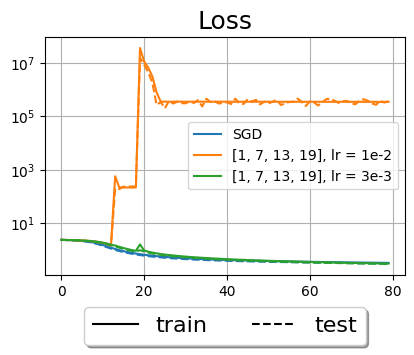

In [465]:
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(4, 2.5))
ax = fig.add_axes([-0.6, -0.6, 0.9, 0.95])

colors = mcolors.TABLEAU_COLORS.keys()

# plt.subplot(1, 2, 1)
plot_lines = []
# items = [list(results.items())[6]] + [list(results.items())[0]] + list(results.items())[7:]
items = list(results.items())
for (name, hists), c in zip(items, colors):
    if name == '[]':
        name = 'SGD'

    l_train, = plt.plot(hists[0], c=c, label=name)
    l_test, = plt.plot(hists[1], c=c, ls='--')
    
    plot_lines += [l_train, l_test]

plt.title('Loss', fontsize=18)
plt.legend()
plt.grid()
plt.yscale('log')

train_marker, = plt.plot(1, 0, c='black', label='train')
test_marker, = plt.plot(1, 0, c='black', ls='--', label='test')
legend1 = plt.legend(handles=[train_marker, test_marker], loc='upper center',
                     bbox_to_anchor=(0.5, -0.09), fancybox=True, shadow=True, ncol=2,
                     fontsize=16)
plt.legend(handles=plot_lines, fontsize=10, ncol=1)
plt.gca().add_artist(legend1)

plt.show()

/var/folders/_s/hy3frgt54mzcdglxl00k5kyw0000gn/T/ipykernel_39161/3517287042.py:29: UserWarning: The label '_child1' of <matplotlib.lines.Line2D object at 0x28e323550> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=plot_lines, fontsize=10)
/var/folders/_s/hy3frgt54mzcdglxl00k5kyw0000gn/T/ipykernel_39161/3517287042.py:29: UserWarning: The label '_child3' of <matplotlib.lines.Line2D object at 0x17f58bf10> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=plot_lines, fontsize=10)
/var/folders/_s/hy3frgt54mzcdglxl00k5kyw0000gn/T/ipykernel_39161/3517287042.py:29: UserWarning: The label '_child5' of <matplotlib.lines.Line2D object at 0x17f58b760> starts with '_'. It is thus excluded from the legend.
  plt.legend(handles=plot_lines, fontsize=10)
/var/folders/_s/hy3frgt54mzcdglxl00k5kyw0000gn/T/ipykernel_39161/3517287042.py:29: UserWarning: The label '_child7' of <matplotlib.lines.Line2D object at 0x17f5b26a0> starts with '_'. It is thus excl

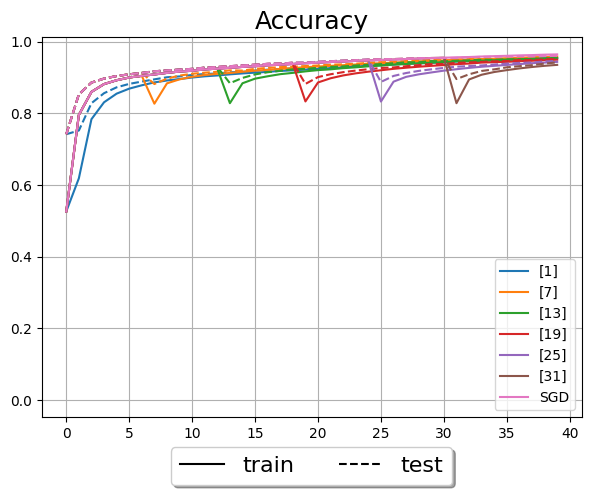

In [438]:
import matplotlib.colors as mcolors

fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes([-0.6, -0.6, 0.9, 0.95])

colors = mcolors.TABLEAU_COLORS.keys()

# plt.subplot(1, 2, 1)
plot_lines = []
for (name, hists), c in zip(results.items(), colors):
    if name == '[]':
        name = 'SGD'

    l_train, = plt.plot(hists[3], c=c, label=name)
    l_test, = plt.plot(hists[4], c=c, ls='--')
    
    plot_lines += [l_train, l_test]

plt.title('Accuracy', fontsize=18)
plt.legend()
plt.grid()
# plt.yscale('log')

train_marker, = plt.plot(1, 0, c='black', label='train')
test_marker, = plt.plot(1, 0, c='black', ls='--', label='test')
legend1 = plt.legend(handles=[train_marker, test_marker], loc='upper center',
                     bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=2,
                     fontsize=16)
plt.legend(handles=plot_lines, fontsize=10)
plt.gca().add_artist(legend1)

plt.show()

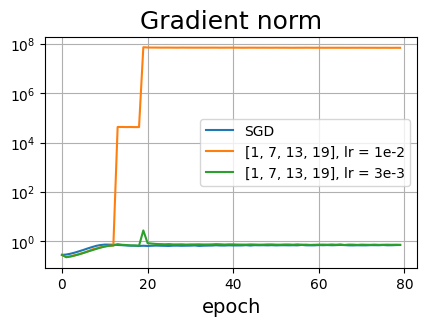

In [467]:
fig = plt.figure(figsize=(4.8, 3))

for (name, hists), c in zip(items, colors):
    if name == '[]':
        name = 'SGD'

    l_train, = plt.plot(hists[2], c=c, label=name)
#     l_test, = plt.plot(hists[1], c=c, ls='--')

plt.title('Gradient norm', fontsize=18)
plt.xlabel('epoch', size=14)
plt.legend(fontsize=10, ncol=1)
plt.grid()
plt.yscale('log')

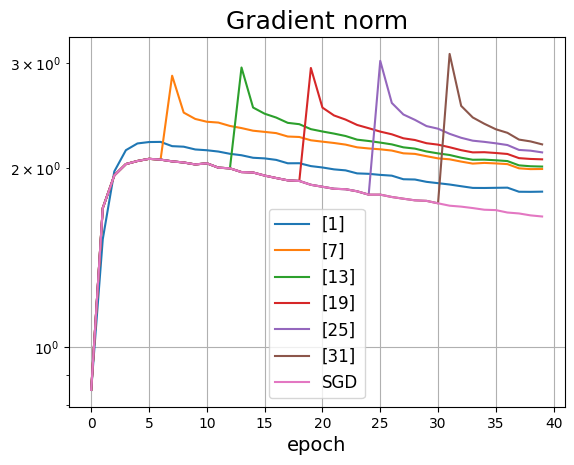

In [416]:
for (name, hists), c in zip(list(results.items()), colors):
    if name == '[]':
        name = 'SGD'

    l_train, = plt.plot(hists[2], c=c, label=name)

plt.title('Gradient norm', fontsize=18)
plt.xlabel('epoch', size=14)
plt.legend()
plt.grid()
plt.yscale('log')

plt.legend(fontsize=12)